# AutoML Image Classification: Added Noise (Digits)

![](imgs/gaussian_noise.png)

In [1]:
import random as rn
from abc import ABC, abstractmethod

import autokeras as ak
import h2o
import matplotlib.pyplot as plt
import numpy as np
from h2o.automl import H2OAutoML
from keras.datasets import fashion_mnist
from numpy.random import RandomState
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier

from dpemu import runner
from dpemu.filters.common import GaussianNoise, Clip
from dpemu.filters.image import RotationPIL
from dpemu.nodes import Array
from dpemu.nodes.series import Series
from dpemu.plotting_utils import visualize_scores, print_results_by_model
from dpemu.utils import generate_tmpdir

/wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/wrk/users/thalvari/dpEmu-AutoML/venv

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


Using TensorFlow backend.


In [2]:
def get_data():
    # random_state = RandomState(42)
    # x, y = load_digits(return_X_y=True)
    # y = y.astype(np.uint8)
    # return train_test_split(x, y, test_size=.2, random_state=random_state)
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    s = x_train.shape[1]
    x_train = x_train.reshape((len(x_train), s**2)).astype(np.float64)
    x_test = x_test.reshape((len(x_test), s**2)).astype(np.float64)
    return x_train, x_test, y_train, y_test

In [3]:
def get_err_root_node():
    # err_img_node = Array(reshape=(8, 8))
    err_img_node = Array(reshape=(28, 28))

    # err_root_node = Series(err_img_node)
    # err_img_node.addfilter(RotationPIL("max_angle"))
    # return err_root_node
    err_root_node = Series(err_img_node)
    err_img_node.addfilter(GaussianNoise("mean", "std"))
    err_img_node.addfilter(Clip("min_val", "max_val"))
    return err_root_node

In [4]:
def get_err_params_list(data):
    # angle_steps = np.linspace(0, 90, num=6)
    # err_params_list = [{"max_angle": a} for a in angle_steps]
    # return err_params_list
    min_val = np.amin(data)
    max_val = np.amax(data)
    std_steps = np.round(np.linspace(0, max_val, num=6), 3)[:4]
    err_params_list = [{"mean": 0, "std": std, "min_val": min_val, "max_val": max_val} for std in std_steps]
    return err_params_list

In [5]:
class Preprocessor:

    def run(self, train_data, test_data, params):
        return np.round(train_data).astype(np.uint8), np.round(test_data).astype(np.uint8), {}

In [6]:
class AbstractModel(ABC):

    def __init__(self):
        self.time_limit_mins = 60*2
        self.seed = 42
        self.random_state = RandomState(self.seed)
        np.random.seed(self.seed)

    @abstractmethod
    def get_fitted_model(self, train_data, train_labels, params):
        pass

    @abstractmethod
    def get_accuracy(self, data, labels, fitted_model, params):
        pass

    @abstractmethod
    def get_best_pipeline(self, fitted_model):
        pass

    def run(self, train_data, test_data, params):
        train_labels = params["train_labels"]
        test_labels = params["test_labels"]

        fitted_model = self.get_fitted_model(train_data, train_labels, params)

        results = {
            "test_acc": self.get_accuracy(test_data, test_labels, fitted_model, params),
            "train_acc": self.get_accuracy(train_data, train_labels, fitted_model, params),
            "best_pipeline": self.get_best_pipeline(fitted_model),
        }
        print(type(fitted_model))
        print(results["test_acc"])
        return results

class TPOTClassifierModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, train_data, train_labels, params):
        return TPOTClassifier(
            max_time_mins=self.time_limit_mins,
            n_jobs=-1,
            random_state=self.seed,
            verbosity=0,
        ).fit(train_data, train_labels)
    
    def get_accuracy(self, data, labels, fitted_model, params):
        return round(fitted_model.score(data, labels), 3)

    def get_best_pipeline(self, fitted_model):
        return [step[1] for step in fitted_model.fitted_pipeline_.steps]

class H2OAutoMLModel(AbstractModel):

    def __init__(self):
        super().__init__()
        h2o.init(name=f"#{rn.SystemRandom().randint(1, 2**30)}")
        h2o.no_progress()

    def get_fitted_model(self, train_data, train_labels, params):
        train_data = h2o.H2OFrame(np.concatenate((train_data, train_labels.reshape(-1, 1)), axis=1))
        x = np.array(train_data.columns)[:-1].tolist()
        y = np.array(train_data.columns)[-1].tolist()
        train_data[y] = train_data[y].asfactor()
        aml = H2OAutoML(max_runtime_secs=60*self.time_limit_mins, seed=self.seed)
        aml.train(x=x, y=y, training_frame=train_data)
        return aml

    def get_accuracy(self, data, labels, fitted_model, params):
        data = h2o.H2OFrame(np.concatenate((data, labels.reshape(-1, 1)), axis=1))
        y = np.array(data.columns)[-1].tolist()
        data[y] = data[y].asfactor()
        pred = fitted_model.predict(data).as_data_frame(header=False)["predict"].values.astype(int)
        return np.round(np.mean(pred == labels), 3)

    def get_best_pipeline(self, fitted_model):
        leader_params = fitted_model.leader.get_params()
        best_pipeline = [leader_params["model_id"]["actual_value"]["name"]]
        if "base_models" in leader_params:
            for base_model in leader_params["base_models"]["actual_value"]:
                best_pipeline.append(base_model["name"])
        h2o.cluster().shutdown()
        return best_pipeline

class AutoKerasModel(AbstractModel):

    def __init__(self):
        super().__init__()
        import tensorflow as tf
        tf.set_random_seed(self.seed)
        import torch
        torch.multiprocessing.set_sharing_strategy("file_system")
        torch.manual_seed(self.seed)

    def get_fitted_model(self, x_train, y_train, params):
        s = np.sqrt(x_train.shape[1]).astype(int)
        x_train = x_train.reshape((len(x_train), s, s, 1))
        clf = ak.ImageClassifier(augment=False, path=generate_tmpdir(), verbose=False)
        clf.fit(x_train, y_train, time_limit=60*self.time_limit_mins)
        return clf

    def get_accuracy(self, x, y, clf, params):
        s = np.sqrt(x.shape[1]).astype(int)
        x = x.reshape((len(x), s, s, 1))
        y_pred = clf.predict(x)
        return np.round(accuracy_score(y_true=y, y_pred=y_pred), 3)

    def get_best_pipeline(self, clf):
        return [m for i, m in enumerate(clf.cnn.best_model.produce_model().modules()) if i > 0]

In [7]:
def get_model_params_dict_list(train_labels, test_labels):
    model_params_base = {"train_labels": train_labels, "test_labels": test_labels}
    return [
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
        {
            "model": TPOTClassifierModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": TPOTClassifierModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
        {
            "model": AutoKerasModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": AutoKerasModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
    ]

In [8]:
def visualize(df):
    visualize_scores(
        df,
        score_names=["test_acc", "train_acc"],
        is_higher_score_better=[True, True],
        # err_param_name="max_angle",
        err_param_name="std",
        title="Classification scores with added error"
    )
    plt.show()

In [9]:
train_data, test_data, train_labels, test_labels = get_data()

df = runner.run(
    train_data=train_data,
    test_data=test_data,
    preproc=Preprocessor,
    preproc_params=None,
    err_root_node=get_err_root_node(),
    # err_params_list=get_err_params_list(),
    err_params_list=get_err_params_list(train_data),
    model_params_dict_list=get_model_params_dict_list(train_labels, test_labels),
    n_processes=1
)

  0%|          | 0/6 [00:00<?, ?it/s]

Checking whether there is an H2O instance running at http://localhost:54321 

.

Checking whether there is an H2O instance running at http://localhost:54321 

.

Checking whether there is an H2O instance running at http://localhost:54321 

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

Checking whether there is an H2O instance running at http://localhost:54321 

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

 not found.

 not found.

 not found.

 not found.

Attempting to start a local H2O server...

Attempting to start a local H2O server...

Attempting to start a local H2O server...

Attempting to start a local H2O server...

 not found.

 not found.

Attempting to start a local H2O server...

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpq8lj4hor

  Ice root: /wrk/users/thalvari/tmpxaqs2jsp

  Ice root: /wrk/users/thalvari/tmpuib_mbe2

  Ice root: /wrk/users/thalvari/tmpzbh5zaid

  Ice root: /wrk/users/thalvari/tmp8vm4ey0p

  Ice root: /wrk/users/thalvari/tmp12qw2ddo

  JVM stdout: /wrk/users/thalvari/tmpq8lj4hor/h2o_thalvari_started_from_python.out

  JVM stdout: /wrk/users/thalvari/tmpxaqs2jsp/h2o_thalvari_started_from_python.out

  JVM stdout: /wrk/users/thalvari/tmpzbh5zaid/h2o_thalvari_started_from_python.out

  JVM stdout: /wrk/users/thalvari/tmpuib_mbe2/h2o_thalvari_started_from_python.out

  JVM stdout: /wrk/users/thalvari/tmp8vm4ey0p/h2o_thalvari_started_from_python.out

  JVM stdout: /wrk/users/thalvari/tmp12qw2ddo/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpzbh5zaid/h2o_thalvari_started_from_python.err

  JVM stderr: /wrk/users/thalvari/tmpxaqs2jsp/h2o_thalvari_started_from_python.err

  JVM stderr: /wrk/users/thalvari/tmpuib_mbe2/h2o_thalvari_started_from_python.err

  JVM stderr: /wrk/users/thalvari/tmpq8lj4hor/h2o_thalvari_started_from_python.err

  JVM stderr: /wrk/users/thalvari/tmp8vm4ey0p/h2o_thalvari_started_from_python.err

  JVM stderr: /wrk/users/thalvari/tmp12qw2ddo/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54325

  Server is running at http://127.0.0.1:54323

  Server is running at http://127.0.0.1:54327

  Server is running at http://127.0.0.1:54331

  Server is running at http://127.0.0.1:54329

Connecting to H2O server at http://127.0.0.1:54323 ..

Connecting to H2O server at http://127.0.0.1:54327 ..

Connecting to H2O server at http://127.0.0.1:54329 ..

Connecting to H2O server at http://127.0.0.1:54331 ..

Connecting to H2O server at http://127.0.0.1:54325 ..

.

.

.

.

.

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

 successful.

 successful.

 successful.

 successful.

 successful.

H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#977930820
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#649843657
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#832056971
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#713517623
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#742561930
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#84004632
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_8e3f closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp95y6_8b7

  JVM stdout: /wrk/users/thalvari/tmp95y6_8b7/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp95y6_8b7/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54331

Connecting to H2O server at http://127.0.0.1:54331 ..

.

 successful.

H2O cluster uptime:,07 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,5 days
H2O cluster name:,#827686798
H2O cluster total nodes:,1
H2O cluster free memory:,26.64 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_829a closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmprsdtji_b

  JVM stdout: /wrk/users/thalvari/tmprsdtji_b/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmprsdtji_b/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54325

Connecting to H2O server at http://127.0.0.1:54325 ..

.

 successful.

H2O cluster uptime:,05 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,5 days
H2O cluster name:,#337379529
H2O cluster total nodes:,1
H2O cluster free memory:,26.64 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b118 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpcgy44i2d

  JVM stdout: /wrk/users/thalvari/tmpcgy44i2d/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpcgy44i2d/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54329

Connecting to H2O server at http://127.0.0.1:54329 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,5 days
H2O cluster name:,#723918604
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_8554 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpz7m1hbm4

  JVM stdout: /wrk/users/thalvari/tmpz7m1hbm4/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpz7m1hbm4/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54327

Connecting to H2O server at http://127.0.0.1:54327 ..

.

 successful.

H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,5 days
H2O cluster name:,#427289250
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_a1bb closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpcabezbj_

  JVM stdout: /wrk/users/thalvari/tmpcabezbj_/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpcabezbj_/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54333

Connecting to H2O server at http://127.0.0.1:54333 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,5 days
H2O cluster name:,#802825514
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_bc0c closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp71je3ayy

  JVM stdout: /wrk/users/thalvari/tmp71je3ayy/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp71je3ayy/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,5 days
H2O cluster name:,#903566331
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b110 closed.

H2O session _sid_aba0 closed.

H2O session _sid_81ca closed.

H2O session _sid_99cd closed.

H2O session _sid_b69a closed.

H2O session _sid_b6a2 closed.

123.87438038333333 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

LogisticRegression(SelectPercentile(input_matrix, percentile=67), C=0.0001, dual=True, penalty=l2)

123.91888841666668 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

LogisticRegression(SelectPercentile(input_matrix, percentile=69), C=0.0001, dual=True, penalty=l2)

123.18062405 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

MultinomialNB(SelectFwe(MaxAbsScaler(CombineDFs(input_matrix, input_matrix)), alpha=0.033), alpha=100.0, fit_prior=False)

/wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


/wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


/wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


/wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


123.04949135 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.25, min_samples_leaf=1, min_samples_split=12, n_estimators=100), n_neighbors=6, p=2, weights=distance)

123.19517466666666 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

XGBClassifier(KNeighborsClassifier(SelectFwe(input_matrix, alpha=0.025), n_neighbors=39, p=2, weights=uniform), learning_rate=0.01, max_depth=9, min_child_weight=5, n_estimators=100, nthread=1, subsample=0.45)

124.00637188333333 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

LogisticRegression(PolynomialFeatures(LogisticRegression(PCA(input_matrix, iterated_power=6, svd_solver=randomized), C=0.0001, dual=True, penalty=l2), degree=2, include_bias=False, interaction_only=False), C=5.0, dual=True, penalty=l2)

124.98583468333332 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(Normalizer(ZeroCount(RandomForestClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.9000000000000001, min_samples_leaf=7, min_samples_split=9, n_estimators=100)), norm=l1), n_neighbors=4, p=2, weights=distance)

124.69619626666666 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

GradientBoostingClassifier(GaussianNB(KNeighborsClassifier(MaxAbsScaler(ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=gini, max_features=0.25, min_samples_leaf=7, min_samples_split=17, n_estimators=100)), n_neighbors=1, p=2, weights=distance)), learning_rate=0.1, max_depth=2, max_features=0.2, min_samples_leaf=19, min_samples_split=14, n_estimators=100, subsample=0.8500000000000001)

120.51142301666667 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

LogisticRegression(PolynomialFeatures(StandardScaler(input_matrix), degree=2, include_bias=False, interaction_only=False), C=25.0, dual=False, penalty=l1)

126.49185053333333 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

GradientBoostingClassifier(GaussianNB(KNeighborsClassifier(MaxAbsScaler(ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=gini, max_features=0.25, min_samples_leaf=7, min_samples_split=17, n_estimators=100)), n_neighbors=1, p=2, weights=distance)), learning_rate=0.1, max_depth=2, max_features=0.2, min_samples_leaf=19, min_samples_split=14, n_estimators=100, subsample=0.8500000000000001)

120.85200493333333 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(Normalizer(Normalizer(BernoulliNB(DecisionTreeClassifier(LogisticRegression(input_matrix, C=0.1, dual=False, penalty=l1), criterion=entropy, max_depth=9, min_samples_leaf=18, min_samples_split=6), alpha=100.0, fit_prior=False), norm=l2), norm=l1), n_neighbors=3, p=2, weights=distance)

158.5992330166667 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

LogisticRegression(PolynomialFeatures(BernoulliNB(PCA(input_matrix, iterated_power=2, svd_solver=randomized), alpha=0.1, fit_prior=True), degree=2, include_bias=False, interaction_only=False), C=0.5, dual=True, penalty=l2)

 17%|█▋        | 1/6 [12:00:50<60:04:14, 43250.90s/it]

 50%|█████     | 3/6 [12:39:29<25:31:10, 30623.42s/it]

100%|██████████| 6/6 [12:39:29<00:00, 7594.91s/it]    

'AutoKeras #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.45,0.457,0.092,0,7214.02
3.2,0.597,0.614,0.089,0,7209.85
6.4,0.111,0.134,0.081,0,7439.71
9.6,0.111,0.097,0.074,0,7216.39
12.8,0.097,0.102,0.129,0,8869.64
16,0.111,0.098,0.128,0,7224.98


'AutoKerasClean #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.811,0.81,0.092,0,7257.1
3.2,0.475,0.638,0.089,0,7245.25
6.4,0.325,0.758,0.081,0,7203.02
9.6,0.203,0.788,0.074,0,7247.68
12.8,0.094,0.267,0.129,0,7205.42
16,0.094,0.272,0.128,0,7222.42


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75
0,"Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),GlobalAvgPool2d(),"Linear(in_features=512, out_features=10, bias=True)"
3.2,"Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padd

'H2OAutoML #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.986,1,0.092,0,6873.06
3.2,0.969,1,0.089,0,6794.31
6.4,0.853,1,0.081,0,6854.47
9.6,0.653,1,0.074,0,6471.24
12.8,0.475,1,0.129,0,5942.17
16,0.417,0.467,0.128,0,5303.5


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75,pipe_76,pipe_77,pipe_78,pipe_79,pipe_80,pipe_81,pipe_82,pipe_83,pipe_84,pipe_85,pipe_86,pipe_87,pipe_88,pipe_89,pipe_90,pipe_91,pipe_92,pipe_93,pipe_94,pipe_95,pipe_96,pipe_97,pipe_98,pipe_99,pipe_100,pipe_101,pipe_102,pipe_103,pipe_104,pipe_105,pipe_106,pipe_107,pipe_108,pipe_109,pipe_110,pipe_111,pipe_112,pipe_113,pipe_114,pipe_115,pipe_116,pipe_117,pipe_118,pipe_119,pipe_120,pipe_121,pipe_122,pipe_123,pipe_124,pipe_125,pipe_126,pipe_127,pipe_128,pipe_129,pipe_130,pipe_131,pipe_132,pipe_133,pipe_134,pipe_135,pipe_136,pipe_137,pipe_138,pipe_139,pipe_140,pipe_141,pipe_142,pipe_143,pipe_144,pipe_145
0,StackedEnsemble_AllModels_AutoML_20191023_002546,DeepLearning_grid_1_AutoML_20191023_002546_model_2,GBM_grid_1_AutoML_20191023_002546_model_40,DeepLearning_grid_1_AutoML_20191023_002546_model_10,GBM_grid_1_AutoML_20191023_002546_model_31,GBM_grid_1_AutoML_20191023_002546_model_18,DeepLearning_grid_1_AutoML_20191023_002546_model_16,GBM_grid_1_AutoML_20191023_002546_model_39,GBM_grid_1_AutoML_20191023_002546_model_19,DeepLearning_grid_1_AutoML_20191023_002546_model_3,DeepLearning_grid_1_AutoML_20191023_002546_model_4,GBM_grid_1_AutoML_20191023_002546_model_46,GBM_grid_1_AutoML_20191023_002546_model_41,DeepLearning_grid_1_AutoML_20191023_002546_model_1,XGBoost_grid_1_AutoML_20191023_002546_model_13,DeepLearning_grid_1_AutoML_20191023_002546_model_13,DeepLearning_grid_1_AutoML_20191023_002546_model_9,GBM_grid_1_AutoML_20191023_002546_model_15,GBM_grid_1_AutoML_20191023_002546_model_35,GBM_2_AutoML_20191023_002546,DeepLearning_grid_1_AutoML_20191023_002546_model_15,GBM_grid_1_AutoML_20191023_002546_model_43,GBM_grid_1_AutoML_20191023_002546_model_55,GBM_grid_1_AutoML_20191023_002546_model_3,DeepLearning_grid_1_AutoML_20191023_002546_model_19,GBM_3_AutoML_20191023_002546,GBM_grid_1_AutoML_20191023_002546_model_45,GBM_grid_1_AutoML_20191023_002546_model_32,GBM_grid_1_AutoML_20191023_002546_model_26,GBM_grid_1_AutoML_20191023_002546_model_47,GBM_grid_1_AutoML_20191023_002546_model_6,GBM_grid_1_AutoML_20191023_002546_model_27,GBM_grid_1_AutoML_20191023_002546_model_48,DeepLearning_grid_1_AutoML_20191023_002546_model_17,DeepLearning_grid_1_AutoML_20191023_002546_model_6,GBM_grid_1_AutoML_20191023_002546_model_20,GBM_grid_1_AutoML_20191023_002546_model_57,GBM_grid_1_AutoML_20191023_002546_model_59,DeepLearning_grid_1_AutoML_20191023_002546_model_5,GBM_5_AutoML_20191023_002546,XGBoost_grid_1_AutoML_20191023_002546_model_33,GBM_grid_1_AutoML_20191023_002546_model_12,GBM_grid_1_AutoML_20191023_002546_model_63,GBM_4_AutoML_20191023_002546,XGBoost_grid_1_AutoML_20191023_002546_model_38,GBM_grid_1_AutoML_20191023_002546_model_56,GLM_grid_1_AutoML_20191023_002546_model_1,GBM_grid_1_AutoML_20191023_002546_model_17,XGBoost_grid_1_AutoML_20191023_002546_model_35,DeepLearning_grid_1_AutoML_20191023_002546_model_14,XGBoost_grid_1_AutoML_20191023_002546_model_46,XRT_1_AutoML_20191023_002546,GBM_grid_1_AutoML_20191023_002546_model_1,GBM_grid_1_AutoML_20191023_002546_model_10,XGBoost_grid_1_AutoML_20191023_002546_model_8,XGBoost_grid_1_AutoML_20191023_002546_model_45,GBM_1_AutoML_20191023_002546,GBM_grid_1_AutoML_20191023_002546_model_14,GBM_grid_1_AutoML_20191023_002546_model_42,DeepLearning_grid_1_AutoML_20191023_002546_model_18,GBM_grid_1_AutoML_20191023_002546_model_11,XGBoost_grid_1_AutoML_20191023_002546_model_30,GBM_grid_1_AutoML_20191023_002546_model_16,GBM_

'H2OAutoMLClean #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.986,1,0.092,0,7155.45
3.2,0.886,1,0.089,0,7131.43
6.4,0.647,1,0.081,0,7075.1
9.6,0.531,1,0.074,0,7245.2
12.8,0.378,1,0.129,0,7536.28
16,0.297,1,0.128,0,7973.14


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75,pipe_76,pipe_77,pipe_78,pipe_79,pipe_80,pipe_81,pipe_82,pipe_83,pipe_84,pipe_85,pipe_86,pipe_87,pipe_88,pipe_89,pipe_90,pipe_91,pipe_92,pipe_93,pipe_94,pipe_95,pipe_96,pipe_97,pipe_98,pipe_99,pipe_100,pipe_101,pipe_102,pipe_103,pipe_104,pipe_105,pipe_106,pipe_107,pipe_108,pipe_109,pipe_110,pipe_111,pipe_112,pipe_113,pipe_114,pipe_115,pipe_116,pipe_117,pipe_118,pipe_119,pipe_120,pipe_121,pipe_122,pipe_123,pipe_124,pipe_125,pipe_126,pipe_127,pipe_128,pipe_129,pipe_130,pipe_131,pipe_132,pipe_133,pipe_134,pipe_135,pipe_136,pipe_137,pipe_138,pipe_139,pipe_140,pipe_141,pipe_142,pipe_143,pipe_144,pipe_145,pipe_146,pipe_147,pipe_148,pipe_149,pipe_150,pipe_151,pipe_152,pipe_153,pipe_154,pipe_155,pipe_156,pipe_157,pipe_158,pipe_159,pipe_160,pipe_161,pipe_162,pipe_163,pipe_164,pipe_165,pipe_166,pipe_167,pipe_168,pipe_169,pipe_170,pipe_171,pipe_172,pipe_173,pipe_174,pipe_175,pipe_176,pipe_177,pipe_178
0,StackedEnsemble_AllModels_AutoML_20191023_022022,DeepLearning_grid_1_AutoML_20191023_022022_model_2,GBM_grid_1_AutoML_20191023_022022_model_40,DeepLearning_grid_1_AutoML_20191023_022022_model_3,GBM_grid_1_AutoML_20191023_022022_model_31,GBM_grid_1_AutoML_20191023_022022_model_18,DeepLearning_grid_1_AutoML_20191023_022022_model_9,GBM_grid_1_AutoML_20191023_022022_model_39,GBM_grid_1_AutoML_20191023_022022_model_19,DeepLearning_grid_1_AutoML_20191023_022022_model_15,GBM_grid_1_AutoML_20191023_022022_model_46,GBM_grid_1_AutoML_20191023_022022_model_41,DeepLearning_grid_1_AutoML_20191023_022022_model_1,XGBoost_grid_1_AutoML_20191023_022022_model_13,GBM_grid_1_AutoML_20191023_022022_model_15,GBM_grid_1_AutoML_20191023_022022_model_35,GBM_2_AutoML_20191023_022022,DeepLearning_grid_1_AutoML_20191023_022022_model_8,GBM_grid_1_AutoML_20191023_022022_model_43,GBM_grid_1_AutoML_20191023_022022_model_55,DeepLearning_grid_1_AutoML_20191023_022022_model_5,GBM_grid_1_AutoML_20191023_022022_model_3,DeepLearning_grid_1_AutoML_20191023_022022_model_14,GBM_3_AutoML_20191023_022022,GBM_grid_1_AutoML_20191023_022022_model_45,GBM_grid_1_AutoML_20191023_022022_model_32,GBM_grid_1_AutoML_20191023_022022_model_26,GBM_grid_1_AutoML_20191023_022022_model_47,DeepLearning_grid_1_AutoML_20191023_022022_model_18,GBM_grid_1_AutoML_20191023_022022_model_6,GBM_grid_1_AutoML_20191023_022022_model_27,GBM_grid_1_AutoML_20191023_022022_model_48,DeepLearning_grid_1_AutoML_20191023_022022_model_12,DeepLearning_grid_1_AutoML_20191023_022022_model_17,GBM_grid_1_AutoML_20191023_022022_model_20,DeepLearning_grid_1_AutoML_20191023_022022_model_4,GBM_grid_1_AutoML_20191023_022022_model_57,GBM_grid_1_AutoML_20191023_022022_model_59,GBM_5_AutoML_20191023_022022,GBM_grid_1_AutoML_20191023_022022_model_63,XGBoost_grid_1_AutoML_20191023_022022_model_33,GBM_grid_1_AutoML_20191023_022022_model_12,DeepLearning_grid_1_AutoML_20191023_022022_model_16,DeepLearning_grid_1_AutoML_20191023_022022_model_10,DeepLearning_grid_1_AutoML_20191023_022022_model_6,GBM_4_AutoML_20191023_022022,GBM_grid_1_AutoML_20191023_022022_model_66,XGBoost_grid_1_AutoML_20191023_022022_model_38,GBM_grid_1_AutoML_20191023_022022_model_56,GLM_grid_1_AutoML_20191023_022022_model_1,XGBoost_grid_1_AutoML_20191023_022022_model_52,GBM_grid_1_AutoML_20191023_022022_model_17,XGBoost_grid_1_AutoML_20191023_022022_model_35,XGBoost_grid_1_AutoML_20191023_022022_model_55,XGBoost_grid_1_AutoML_20191023_022022_model_46,GBM_grid_1_AutoML_20191023

'TPOTClassifier #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.989,1,0.092,0,7484.18
3.2,0.967,1,0.089,0,7388.9
6.4,0.847,0.862,0.081,0,7413.8
9.6,0.639,0.66,0.074,0,7391.64
12.8,0.508,0.527,0.129,0,7436.46
16,0.397,0.447,0.128,0,7435.55


std,pipe_0,pipe_1,pipe_2,pipe_3
0,"PCA(copy=True, iterated_power=6, n_components=None, random_state=None, svd_solver='randomized', tol=0.0, whiten=False)","StackingEstimator(estimator=LogisticRegression(C=0.0001, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False))","PolynomialFeatures(degree=2, include_bias=False, interaction_only=False, order='C')","LogisticRegression(C=5.0, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False)"
3.2,"StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy', max_depth=None, max_features=0.25, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=12, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=6, p=2, weights='distance')",nan,nan
6.4,"SelectFwe(alpha=0.025, score_func=)","StackingEstimator(estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=39, p=2, weights='uniform'))","XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=9, min_child_weight=5, missing=nan, n_estimators=100, n_jobs=1, nthread=1, objective='multi:softprob', random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=None, subsample=0.45, verbosity=1)",nan
9.6,"FeatureUnion(n_jobs=None, transformer_list=[('functiontransformer-1', FunctionTransformer(accept_sparse=False, check_inverse=True, func=, inv_kw_args=None, inverse_func=None, kw_args=None, pass_y='deprecated', validate=None)), ('functiontransformer-2', FunctionTransformer(accept_sparse=False, check_inverse=True, func=, inv_kw_args=None, inverse_func=None, kw_args=None, pass_y='deprecated', validate=None))], transformer_weights=None, verbose=False)",MaxAbsScaler(copy=True),"SelectFwe(alpha=0.033, score_func=)","MultinomialNB(alpha=100.0, class_prior=None, fit_prior=False)"
12.8,"SelectPercentile(percentile=69, score_func=)","LogisticRegression(C=0.0001, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False)",nan,nan
16,"SelectPercentile(percentile=67, score_func=)","LogisticRegression(C=0.0001, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False)",nan,nan


'TPOTClassifierClean #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.986,1,0.092,0,7266.06
3.2,0.375,1,0.089,0,7256.96
6.4,0.772,1,0.081,0,9582.7
9.6,0.253,1,0.074,0,7610.09
12.8,0.178,1,0.129,0,7492.04
16,0.317,1,0.128,0,7505.92


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5
0,"StackingEstimator(estimator=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l1', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False))","StackingEstimator(estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=9, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=18, min_samples_split=6, min_weight_fraction_leaf=0.0, presort=False, random_state=None, splitter='best'))","StackingEstimator(estimator=BernoulliNB(alpha=100.0, binarize=0.0, class_prior=None, fit_prior=False))","Normalizer(copy=True, norm='l2')","Normalizer(copy=True, norm='l1')","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=3, p=2, weights='distance')"
3.2,"StandardScaler(copy=True, with_mean=True, with_std=True)","PolynomialFeatures(degree=2, include_bias=False, interaction_only=False, order='C')","LogisticRegression(C=25.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l1', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False)",nan,nan,nan
6.4,"PCA(copy=True, iterated_power=2, n_components=None, random_state=None, svd_solver='randomized', tol=0.0, whiten=False)","StackingEstimator(estimator=BernoulliNB(alpha=0.1, binarize=0.0, class_prior=None, fit_prior=True))","PolynomialFeatures(degree=2, include_bias=False, interaction_only=False, order='C')","LogisticRegression(C=0.5, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False)",nan,nan
9.6,"StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini', max_depth=None, max_features=0.25, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=7, min_samples_split=17, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False))",MaxAbsScaler(copy=True),"StackingEstimator(estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=1, p=2, weights='distance'))","StackingEstimator(estimator=GaussianNB(priors=None, var_smoothing=1e-09))","GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.1, loss='deviance', max_depth=2, max_features=0.2, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=19, min_samples_split=14, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto', random_state=None, subsample=0.8500000000000001, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)",nan
12.8,"StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini', max_depth=None, max_features=0.25, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=7, min_samples_split=17, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False))",MaxAbsScaler(copy=True),"StackingEstimator(estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=1, p=2, weights='distance'))","StackingEstimator(estimator=GaussianNB(priors=None, var_smoothing=1e-09))","GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.1, loss='deviance', max_depth=2, max_features=0.2, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=19, min_samples_split=14, min_weight_fr

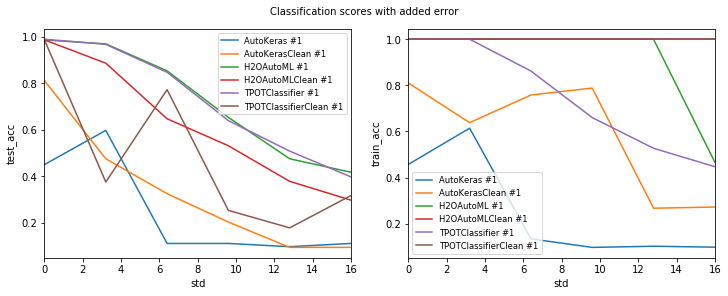

In [10]:
print_results_by_model(df,
    # ["train_labels", "test_labels"],
    ["mean", "min_val", "max_val", "train_labels", "test_labels"], 
    # err_param_name="max_angle",
    err_param_name="std",
    pipeline_name="best_pipeline"
)
visualize(df)